# Maximum Likelihood Estimation (MLE)

## Learning objectives
- Understand mathematically, what it means to find "optimal" parameters
- Derive MLE from scratch
- Quantify the confidence in a particular parameterisation
- Understand why we use the mean squared error loss function for regression tasks rather than say the absolute or quartic squared error

## Intro - what distribution best describes our data?

# comparre the distributions

## How can we quantify this?

The maximum likelihood parameters of a distribution are those which parameterise a given distribution such that the probability of sampling the observed data from it is maximised.

# draw MLE for p(x).


Let's visualise some unsupervised data (no labels) so that we can try to fit a distribution to it using maximum likelihood.

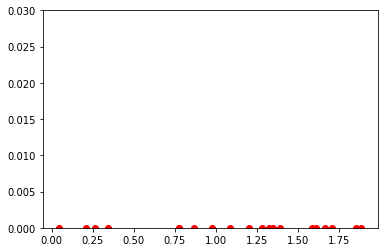

mean: 1.111077925132593
standard deviation: 0.5517488860781299


In [18]:
# DON'T WORRY ABOUT THIS CELL, IT JUST SETS SOME STUFF UP
import numpy as np
import matplotlib.pyplot as plt
from utils import get_regression_data, show_regression_data

X, Y = get_regression_data()

X = X[:, 0]
Y = np.zeros_like(Y)

plt.scatter(X, np.zeros(X.shape[0]), c='r')
plt.ylim(0, 0.03)
plt.show()

mu = np.mean(X)
sigma = np.std(X)
print('mean:', mu)
print('standard deviation:', sigma)


We will model our data with a Gaussian (normal distribution). Let's code one up now.

# Gaussian function drawing

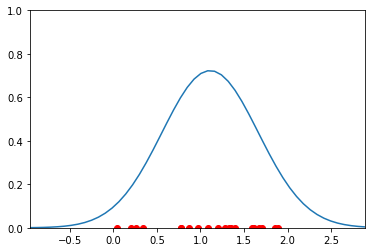

In [26]:
import numpy as np

class GaussianPDF:
    def __init__(self, mu=0, sigma=1):
        self.mu = mu
        self.sigma = sigma

    def __call__(self, x):
        p_x = np.exp(-(x - self.mu)**2 / (2*self.sigma**2)) / ( np.sqrt(2*np.pi) * self.sigma) # pdf equation for gaussian
        return p_x

p = GaussianPDF(mu, sigma)

p(0)
domain = np.linspace(min(X)-1, max(X)+1)
plt.plot(domain, p(domain))
plt.scatter(X, np.zeros(X.shape[0]), c='r')
plt.ylim(0, 1)
plt.xlim(min(domain), max(domain))
plt.show()

What is the central position (mean) of the Gaussian distribution which best describes the feature values of the data, assuming that they are normally distributed?

Let's test out different Gaussian distributions by evaluating the likelihood of our dataset being sampled from each of them, using the formula we derived above.

[0.04691407 0.08443303 0.12195199 0.15947094 0.1969899  0.23450885
 0.27202781 0.30954676 0.34706572 0.38458468 0.42210363 0.45962259
 0.49714154 0.5346605  0.57217945 0.60969841 0.64721737 0.68473632
 0.72225528 0.75977423 0.79729319 0.83481214 0.8723311  0.90985006
 0.94736901 0.98488797 1.02240692 1.05992588 1.09744484 1.13496379
 1.17248275 1.2100017  1.24752066 1.28503961 1.32255857 1.36007753
 1.39759648 1.43511544 1.47263439 1.51015335 1.5476723  1.58519126
 1.62271022 1.66022917 1.69774813 1.73526708 1.77278604 1.81030499
 1.84782395 1.88534291]
-53.67308064179628
-51.0984313953607
-48.61582094113744
-46.22534538969735
-43.92707882801422
-41.72107857403309
-39.60738913492483
-37.586045197409554
-35.657073893675054
-33.82049652374358
-32.07632986884845
-30.42458719615956
-28.865279029859995
-27.398413744783582
-26.023998024852474
-24.742037218142496
-23.552535612623597
-22.455496650791584
-21.450923097021416
-20.53881716816356
-19.71918063539582
-18.9920149034329
-18.35732107173

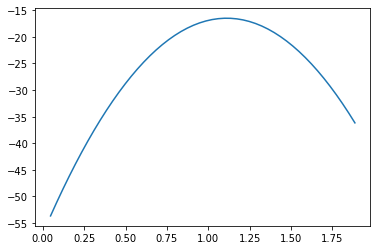

In [47]:

mus = np.linspace(min(X), max(X), 50)
print(mus)
objectives = np.zeros_like(mus)
best_mu = 0
best_val = -float('inf') # initialise best value as infinitely bad
for idx, m in enumerate(mus):
    p = GaussianPDF(m, sigma)
    obj = 0
    for x in X:
        obj += np.log(p(x) + 0.00001) # what is this added constant? Find out what happens if you remove it. Why does this happen?
    objectives[idx] = obj
    if obj > best_val:
        best_val = obj
        best_mu = m
    print(obj)

print('BEST VAL:', best_val)
print('BEST MU:', best_mu)

# plt.ylim(-300, 0)
# plt.xlim(0, 10)
plt.plot(mus, objectives)


## Now let's look at the supervised case

Let's now consider the case where our dataset contains labels as well as just example features.

We can follow the same steps to find an objective function for solving supervised regression problems. We simply model the conditional distribution over the labels given features, rather than modelling the distribution of features.

# $P(Y|X;\theta)$

So for every input, we are going to have our model output a distribution, rather than a point estimate. How can we do this? Simply by having the output of our model be the parameterisation for a gaussian distribution over the values of the label. In this case we will assume that the variance of these distributions is fixed; it will not affect the argmax of the distribution anyway.

We assume that the distribution over labels is Gaussian because of the [central limit theorem]()

Below is a plot that shows the features, along with distributions over their labels if our model were able to predict the correct mean of the distribution for each example. It also assumes that the distributions have unit variance.

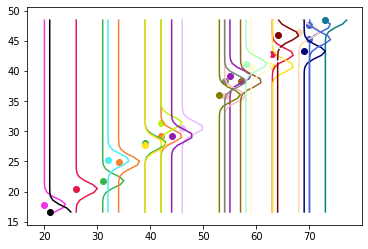

In [25]:
from get_colors import colors

def plot_dist(x, y, color='blue'):
    domain = np.linspace(min(Y), max(Y))
    p = GaussianPDF(y, 1)
    p_plot = 10*p(domain) + x
    plt.plot(p_plot, domain, c=colors[i%len(colors)])

for i in range(len(X)):
    x = X[i]
    y = Y[i]
    domain = np.linspace(min(Y), max(Y))
    p = GaussianPDF(y, 1)
    p_plot = 10*p(domain) + x
    plt.scatter(x, y, c=colors[i%len(colors)])
    # plt.plot(p_plot, domain, c=colors[i%len(colors)])
    plot_dist(x, y)
plt.show()


## Now let's actually use our model to produce the distributions over labels for each input example


0.7107585868204024


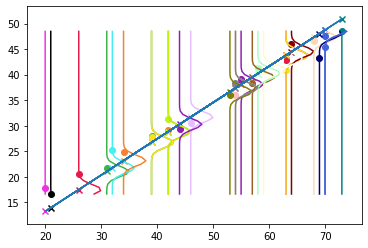

In [32]:
grad = (Y[-1] - Y[0]) / (X[-1] - X[0])
print(grad)

class LinearModel:
    def __init__(self, w, b):
        self.w = w
        self.b = b

    def __call__(self, x):
        return self.b + self.w * x

model = LinearModel(grad, -1)

for i in range(len(X)):
    color = colors[i%len(colors)]
    plt.scatter(X[i], Y[i], c=color)
    plt.scatter(X[i], model(X[i]), marker='x', c=color)
    plot_dist(X[i], model(X[i]))
    # plt.legend()
plt.plot(X, model(X))
plt.show()


## Linear regression as maximum likelihood

Previously we implemented a linear regression algorithm that made a point estimate of the label $y$ given an input $x$.
We chose to minimise the mean squared error somewhat arbitrarily. Why did we choose this as our criterion? Why not minimise the absolute error or the mean quartic error?

We want to find the parameters of the model that we have defined that best describe the data. That is, the maximum likelihood parameters $\theta_{ML}$.
Somehow we need to link the probability distributions produced by our model parameterisation 

Let's revisit the linear regression algorithm from a perspective of maximum likelihood.
Rather than predicting a point estimate, we now have the model predict a conditional probability distribution $p(y|x;\theta)$ over the label $y$ given $x$.
That means that our model is predicting the confidence of the label taking one of a range of possible values, rather than predicting the exact value, for each example input.

To yield the same linear regression learning algorithm, we assume that the distribution over labels for a given example is a Gaussian.
# Is this because of the central limit theorem?

# This is our first encounter with injecting prior knowledge (or an assumption) about the distribution of the data into our model.


## Deriving the mean squared error loss function from maximum likelihood

We know that maximum likelihood means maximising the probability of observing the data predicted by our model. Putting the equation for our assumedly Gaussian probability distribution into the objective that we defined earlier transforms it into the same objective that we minimised previously - the mean squared error.

# derive MSE from MLE

This should highlight why the MSE loss is what we optimise for, rather than any other arbitrary loss function such as absolute error.

## Properties of maximum likelihood

### The maximum likelihood estimator is a **consistent** estimator
This means that as the number of training examples approaches infinity, the maximum likelihood estimate of the parameter converges to the true value of the parameter.

### Statistical efficiency


## Summary
- Maximum Likelihood Estimation is a procedure for finding parameters that best describe a set of data
- The reason that we minimise MSE is because it is the objective produced by plugging a Gaussian distribution into the maximum likelihood objective